## Setup

### Library loading

In [15]:
# system imports
import sys, os, json, pickle
from pathlib import Path

# utility imports
from tqdm import tqdm
from itertools import product

# data science imports
import numpy as np, pandas as pd, scipy.sparse as sp, scipy.stats as stats

# plotting imports
import matplotlib.pyplot as plt, matplotlib.colors as mcolors, plotly.express as px, plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap

# ensure project root on path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
	sys.path.insert(0, project_root)

# imports from src
from src.twsbm import TWSBM
from src.tdcsbm import TDCSBM
from src.metrics import *
from src.transformations import *
from src.models.beta import *
from src.models.lognorm import *
from src.models.wdcsbm import *

### Transformations selection

In [16]:
FAMILIES = {
	'classical': [
		QuantileTransform(q=0.1),
		QuantileTransform(q=0.25),
		QuantileThresholding(q=0.1),
		QuantileThresholding(q=0.25),
		PowerTransform(γ=0.5),
		PowerTransform(γ=1), # identity
		PowerTransform(γ=2),
		LogPowerTransform(γ=0.5),
		LogPowerTransform(γ=1), # log
		LogPowerTransform(γ=2),
	],
	'qtl_05': [QuantileTransform(q) for q in np.linspace(0, 0.5, 6)[1:]],
	'qtl_10': [QuantileTransform(q) for q in np.linspace(0, 0.5, 11)[1:]],
	'qtr_05': [QuantileThresholding(q) for q in np.linspace(0, 0.5, 6)[1:]],
	'qtr_10': [QuantileThresholding(q) for q in np.linspace(0, 0.5, 11)[1:]],
	'log_05': [LogPowerTransform(γ) for γ in np.linspace(0.5, 2, 7)],
	'log_10': [LogPowerTransform(γ) for γ in np.linspace(0.5, 2, 13)],
	'pow_05': [PowerTransform(p) for p in np.linspace(0.5, 2, 7)],
	'pow_10': [PowerTransform(p) for p in np.linspace(0.5, 2, 13)]
}

TRANSFORMS = FAMILIES['qtl_10'] + FAMILIES['qtr_10'] + FAMILIES['log_10'] + FAMILIES['pow_10']
TRANSFORMS_MAP_COLOR = {t.id : t.color for t in TRANSFORMS}

FAMILIES_IDX = {
	name: [TRANSFORMS.index(t) for t in transforms]
	for name, transforms in FAMILIES.items()
}

FAMILIES_MAP_COLOR = dict(zip(FAMILIES.keys(), [
	'brown',
	FAMILIES['qtl_10'][0].color,
	FAMILIES['qtl_10'][-1].color,
	FAMILIES['qtr_10'][0].color,
	FAMILIES['qtr_10'][-1].color,
	FAMILIES['log_10'][0].color,
	FAMILIES['log_10'][-1].color,
	FAMILIES['pow_10'][0].color,
	FAMILIES['pow_10'][-1].color
]))

### Utility

In [17]:
out_path = "../reports/figures/stacking_vs_chernoff_argmax/"
def save_img(plot, name, plot_name):
	name = name.replace(' ', '_')
	name, mode = name.rsplit("_", 1)

	os.makedirs(f"{out_path}/by_graph/{name}", exist_ok=True)
	os.makedirs(f"{out_path}/by_plot/{plot_name}", exist_ok=True)

	if isinstance(plot, go.Figure):
		plot.write_image(f"{out_path}/by_graph/{name}/{plot_name}_{mode}.png")
		plot.write_image(f"{out_path}/by_plot/{plot_name}/{name}_{mode}.png")
	else:
		plot.savefig(f"{out_path}/by_graph/{name}/{plot_name}_{mode}.png", dpi=300)
		plot.savefig(f"{out_path}/by_plot/{plot_name}/{name}_{mode}.png", dpi=300)

def to_css_rgba(c):
	if isinstance(c, str):
		return c
	*rgb, a = (c if len(c)==4 else (*c, 1.0))
	r, g, b = [int(round(v*255)) if v<=1 else int(round(v)) for v in rgb]
	return f"rgba({r},{g},{b},{a})"

# Plot ARI heatmap for families
def plot_heatmap_families(name, df_transforms, metadata):
	df = df_transforms.copy()

	families = df.index.tolist()
	metrics = ['Max Ĉ', 'Stacked', 'Max', 'Mean', 'Median']

	best_max_c   = df['Max Ĉ'].max()
	best_stacked = df['Stacked'].max()
	n, K, baseline_ARI, n_samples = metadata['n'], metadata['K'], metadata['baseline_ARI'], metadata['samples']

	data = df.loc[:, metrics].T.to_numpy()
	mask = np.ones_like(data, dtype=bool)
	mask[0:2, :] = False                              # only first two rows are visible
	mdata = np.ma.array(data, mask=mask)              # masked array
	cmap = LinearSegmentedColormap.from_list('red_white_green', [(0, 'red'), (baseline_ARI, 'white'), (1, 'green')])
	cmap = cmap.copy()
	cmap.set_bad('white', alpha=1.0)                  # masked cells = pure white
	norm = mcolors.Normalize(vmin=0, vmax=1)

	fig, ax = plt.subplots(figsize=(8, 6))
	im = ax.imshow(mdata, cmap=cmap, norm=norm, aspect='auto')

	ax.set_xticks(np.arange(len(families)))
	ax.set_xticklabels(families, rotation=45, ha='right')
	ax.set_yticks(np.arange(len(metrics)))
	ax.set_yticklabels(metrics)

	for i, met in enumerate(metrics):
		for j, fam in enumerate(families):
			weight = 'bold' if df.loc[fam, met] in [best_max_c, best_stacked] and i < 2 else 'normal'
			ax.text(j, i, f"{df.loc[fam, met] :.3f}", ha='center', va='center', fontweight=weight)

	ax.axhline(y=1.5, color='black', linewidth=2)
	sample_str = f"#samples = {n_samples}, " if n_samples > 1 else ""
	ax.set_title(
		f"ARI heatmap for transform families on dataset:\n{name.replace('_', ' ')}, "
		f"{sample_str}n = {n}, K = {K}\n"
		f"Baseline ARI = {baseline_ARI:.3f}, Max Ĉ ARI = {best_max_c:.3f}, Max Stacked ARI = {best_stacked:.3f}\n"
	)
	cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
	ax.set_xlabel('Transform Families')
	plt.tight_layout()
	plt.show()

	save_img(fig, name, "heatmap_families")

# Plot ARI bar plot for individual transforms
def plot_bars_transforms(name, df_transforms, metadata):

	df = df_transforms.copy().reset_index()
	df["color"] = df["transform"].map(TRANSFORMS_MAP_COLOR).map(to_css_rgba)
	df_sorted = df.sort_values("ARI", ascending=False)

	sample_str = f"#samples = {metadata['samples']}, " if metadata['samples'] > 1 else ""

	fig = px.bar(
		df_sorted,
		x="transform",
		y="ARI",
		title=f"ARI for transforms on dataset: {name.replace('_', ' ')}<br>"
			  f"{sample_str}n = {metadata['n']}, K = {metadata['K']}, Baseline ARI = {metadata['baseline_ARI']:.3f}",
	)

	fig.update_traces(marker_color=df_sorted["color"])

	fig.add_hline(
		y=metadata["baseline_ARI"],
		line_dash="dash",
		line_color="black",
		annotation_text="Baseline ARI",
		annotation_position="top left"
	)


	for t in [PowerTransform(γ=1), LogPowerTransform(γ=1), QuantileTransform(0.25), QuantileThresholding(0.25)]:
		fig.add_trace(go.Scatter(
			x=[None], y=[None],   # pas de point affiché
			mode="markers",
			marker=dict(size=12, color=to_css_rgba(t.color)),
			name=t.name.split('(')[0]
		))

	fig.update_layout(
		xaxis_tickangle=-45,
		showlegend=True,
		title_x=0.5
	)
	fig.update_xaxes(showticklabels=False, title_text="Transforms")
	fig.update_yaxes(range=[None, 1])
	fig.show()

	save_img(fig, name, "bars_transforms")

# Plot ARI bar plot for families (Max Ĉ vs Stacked) v1
def plot_bars_families_v1(name, df_transforms, metadata, sort_by='Max Ĉ', show_values=False):
	if sort_by not in df_transforms.columns:
		raise ValueError(f"`sort_by` doit être une colonne de df_transforms, reçu {sort_by!r}")

	cols = ['Max Ĉ', 'Stacked']
	for c in cols:
		if c not in df_transforms.columns:
			raise ValueError(f"df_transforms doit contenir la colonne {c!r}")

	df = df_transforms.copy()
	if df.index.name is None:
		df.index.name = 'family'
	families = df.index.tolist()

	order = df.sort_values(by=sort_by, ascending=False).index

	y_maxc   = df.loc[order, 'Max Ĉ'].to_numpy()
	y_stack  = df.loc[order, 'Stacked'].to_numpy()

	baseline = float(metadata.get('baseline_ARI', 0.0))
	n        = metadata.get('n', None)
	K        = metadata.get('K', None)
	samples  = metadata.get('samples', 1)

	fig = go.Figure()

	fig.add_trace(go.Bar(
		name='Max Ĉ',
		x=order,
		y=y_maxc,
		offsetgroup='maxc',
		marker=dict(line=dict(width=0)),
		hovertemplate="<b>%{x}</b><br>Max Ĉ: %{y:.3f}<extra></extra>",
		text=[f"{v:.3f}" for v in y_maxc] if show_values else None,
		textposition="outside" if show_values else None,
		cliponaxis=False if show_values else None,
	))

	fig.add_trace(go.Bar(
		name='Stacked',
		x=order,
		y=y_stack,
		offsetgroup='stacked',
		marker=dict(
			line=dict(width=0),
			pattern=dict(shape="/")  # hachures
		),
		hovertemplate="<b>%{x}</b><br>Stacked: %{y:.3f}<extra></extra>",
		text=[f"{v:.3f}" for v in y_stack] if show_values else None,
		textposition="outside" if show_values else None,
		cliponaxis=False if show_values else None,
	))

	fig.add_hline(
		y=baseline,
		line_dash="dash",
		line_color="black",
		annotation_text="Baseline ARI",
		annotation_position="top left"
	)

	sample_str = f"#samples = {samples}, " if samples and samples > 1 else ""
	fig.update_layout(
		barmode='group',
		bargap=0.25,
		bargroupgap=0.05,
		xaxis_title="Transform Families",
		yaxis_title="ARI",
		yaxis_range=[0, 1],
		xaxis_tickangle=-45,
		title=(
			f"ARI for families (Max Ĉ vs Stacked): {name.replace('_', ' ')}<br>"
			f"{sample_str}n = {n}, K = {K}, Baseline ARI = {baseline:.3f}"
		),
		title_x=0.5,
		showlegend=True,
	)
	fig.update_xaxes(categoryorder='array', categoryarray=list(order))

	fig.show()

	save_img(fig, name, "bars_families_stacked_vs_argmaxc")

# Plot ARI bar plot for families (Max Ĉ vs Stacked) v2
def plot_bars_families_v2(name, df_transforms, metadata):
	required = ['Max Ĉ', 'Stacked']
	for c in required:
		if c not in df_transforms.columns:
			raise ValueError(f"df_transforms doit contenir la colonne {c!r}")

	df = df_transforms.copy()
	if df.index.name is None:
		df.index.name = 'family'

	Max_C_is_not_nan = df['Max Ĉ'].notna().any()

	labels, values, metrics, families = [], [], [], []
	for fam in df.index:
		if Max_C_is_not_nan:
			labels.append(f"{fam} — Max Ĉ")
			values.append(float(df.loc[fam, 'Max Ĉ']))
			metrics.append('Max Ĉ')
			families.append(fam)

		labels.append(f"{fam} — Stacked")
		values.append(float(df.loc[fam, 'Stacked']))
		metrics.append('Stacked')
		families.append(fam)

	order_idx        = np.argsort(values)[::-1]
	ordered_labels   = [labels[i]   for i in order_idx]
	ordered_values   = [values[i]   for i in order_idx]
	ordered_metrics  = [metrics[i]  for i in order_idx]
	ordered_families = [families[i] for i in order_idx]

	x_maxc, y_maxc, c_maxc = [], [], []
	x_stack, y_stack, c_stack = [], [], []
	for lab, val, met, fam in zip(ordered_labels, ordered_values, ordered_metrics, ordered_families):
		col = to_css_rgba(FAMILIES_MAP_COLOR[fam])
		if met == 'Max Ĉ':
			x_maxc.append(lab); y_maxc.append(val); c_maxc.append(col)
		else:
			x_stack.append(lab); y_stack.append(val); c_stack.append(col)

	baseline = float(metadata.get('baseline_ARI', 0.0))
	n        = metadata.get('n', None)
	K        = metadata.get('K', None)
	samples  = metadata.get('samples', 1)

	fig = go.Figure()

	fig.add_trace(go.Bar(
		name='Max Ĉ',
		x=x_maxc,
		y=y_maxc,
		marker=dict(color=c_maxc, line=dict(width=0)),
		hovertemplate="<b>%{x}</b><br>ARI: %{y:.3f}<extra></extra>",
		showlegend=False
	))

	fig.add_trace(go.Bar(
		name='Stacked',
		x=x_stack,
		y=y_stack,
		marker=dict(color=c_stack, line=dict(width=0), pattern=dict(shape="/")),
		hovertemplate="<b>%{x}</b><br>ARI: %{y:.3f}<extra></extra>",
		showlegend=False
	))

	if Max_C_is_not_nan:
		fig.add_trace(go.Bar(
			name='Max Ĉ',
			x=[ordered_labels[0]], y=[0],      # n'importe quelle catégorie existante
			marker=dict(
				color='white',
				line=dict(color='black', width=1)
			),
			hoverinfo='skip',
			visible='legendonly',               # ⟵ n’apparaît pas dans le graphe
			legendrank=1
		))

	fig.add_trace(go.Bar(
		name='Stacked',
		x=[ordered_labels[0]], y=[0],
		marker=dict(
			color='white',
			line=dict(color='black', width=1),
			pattern=dict(shape='/', fgcolor='black', bgcolor='white')
		),
		hoverinfo='skip',
		visible='legendonly',
		legendrank=2
	))

	for fam in df.index:
		fig.add_trace(go.Scatter(
			x=[None], y=[None],
			mode="markers",
			marker=dict(size=12, symbol="square", color=to_css_rgba(FAMILIES_MAP_COLOR[fam])),
			name=fam,
			showlegend=True,
			legendgroup="families"
		))

	fig.add_hline(
		y=baseline,
		line_dash="dash",
		line_color="black",
		annotation_text="Baseline ARI",
		annotation_position="top left"
	)

	Max_C_string = ", Max Ĉ" if Max_C_is_not_nan else ""

	sample_str = f"#samples = {samples}, " if samples and samples > 1 else ""
	fig.update_layout(
		barmode='group',
		bargap=0.25,
		xaxis_title=f"Families (Stacked{Max_C_string})",
		yaxis_title="ARI",
		yaxis_range=[0, 1],
		title=(
			f"ARI for families (Stacked{Max_C_string}) on dataset: {name.replace('_', ' ')}<br>"
			f"{sample_str}n = {n}, K = {K}, Baseline ARI = {baseline:.3f}"
		),
		title_x=0.5,
		showlegend=True,
		legend_tracegroupgap=12,
		legend_title_text=None,
		legend=dict(font=dict(color="black", size=12))  # police noire
	)
	fig.update_xaxes(
		categoryorder='array',
		categoryarray=ordered_labels,
		showticklabels=False,
		ticks=""
	)

	fig.show()

	save_img(fig, name, "bars_families")



### Loading

In [18]:
data_dir = os.path.join(project_root, 'data/processed/graphs')
fn = os.path.join(data_dir, 'df_dict_synthetic.pkl')

with open(fn, 'rb') as f:
	df_dict_synthetic = pickle.load(f)
	
fn = os.path.join(data_dir, 'df_dict_real.pkl')

with open(fn, 'rb') as f:
	df_dict_real = pickle.load(f)

## Plotting

### Synthetic graphs

#### Families ARI heatmaps

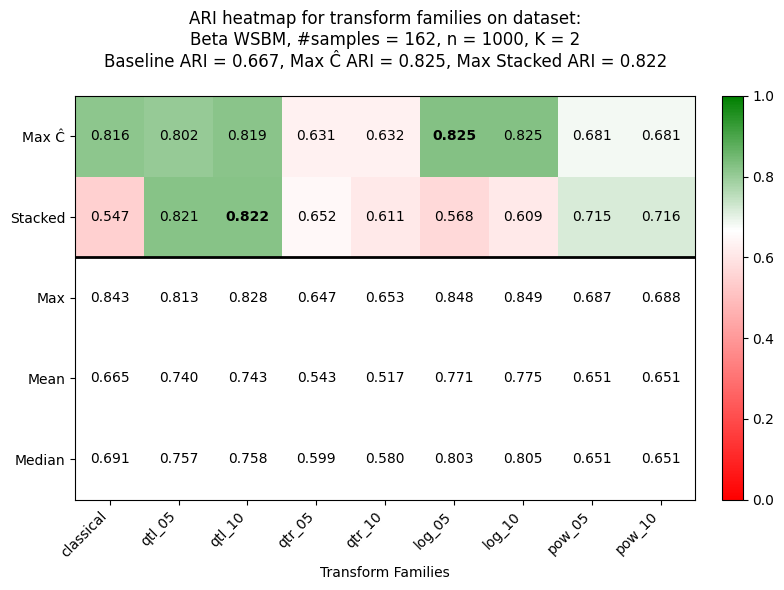

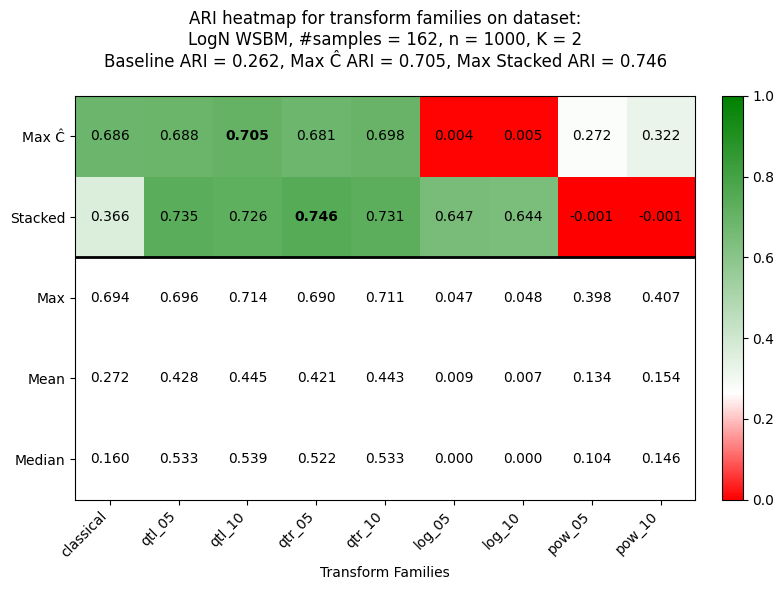

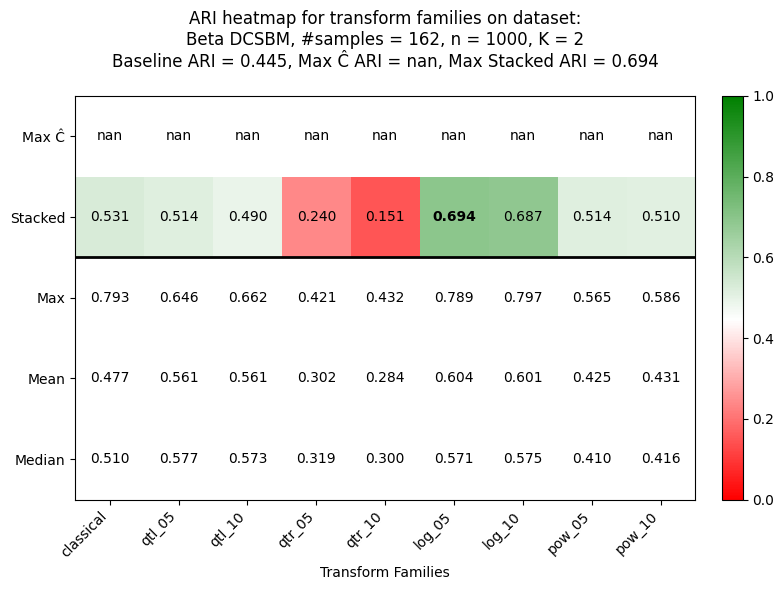

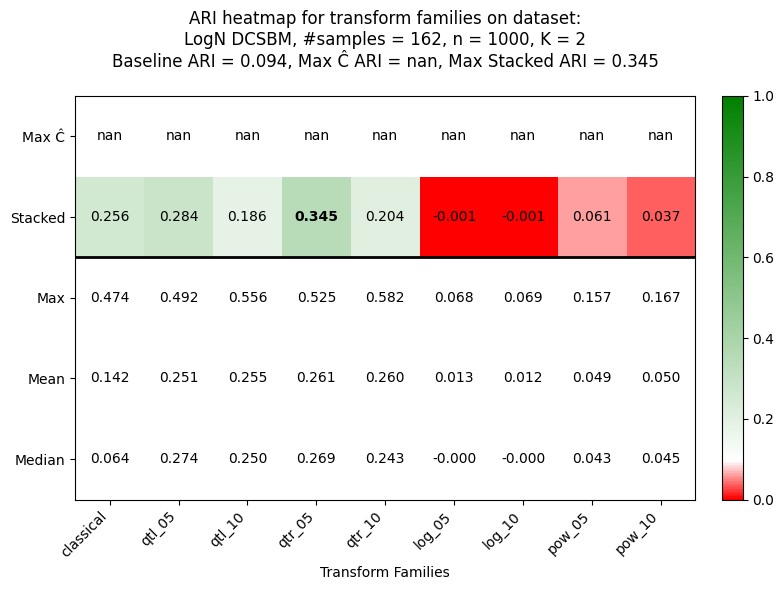

In [19]:
for name, d in df_dict_synthetic.items():
	plot_heatmap_families(name, d['df_families'], d['metadata'])

#### Transforms ARI bar charts

In [20]:
for name, d in df_dict_synthetic.items():
	plot_bars_transforms(name, d['df_transforms'], d['metadata'])

#### Families ARI bar charts v1

In [21]:
for name, d in list(df_dict_synthetic.items())[:2]:
	plot_bars_families_v1(name, d['df_families'], d['metadata'], sort_by='Max Ĉ', show_values=True)

#### Families ARI bar charts v2

In [22]:
for name, d in df_dict_synthetic.items():
	plot_bars_families_v2(name, d['df_families'], d['metadata'])

### Real graphs

#### Families ARI heatmaps

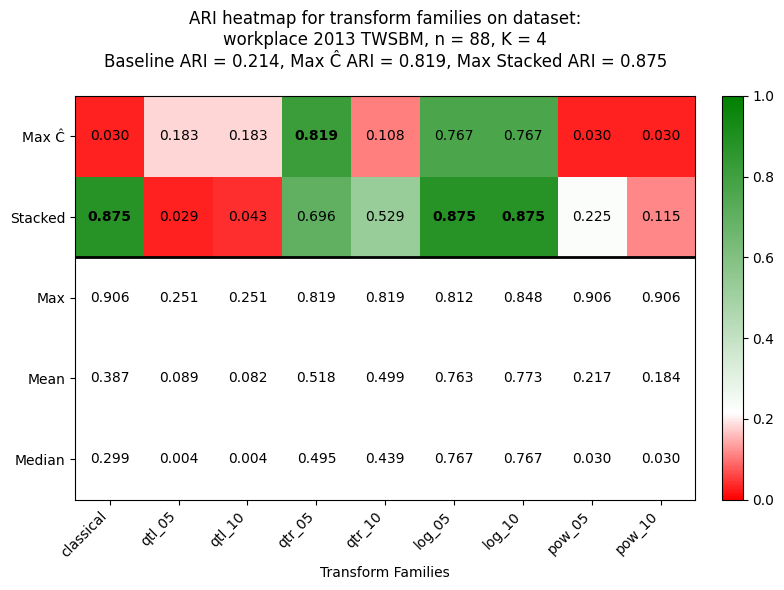

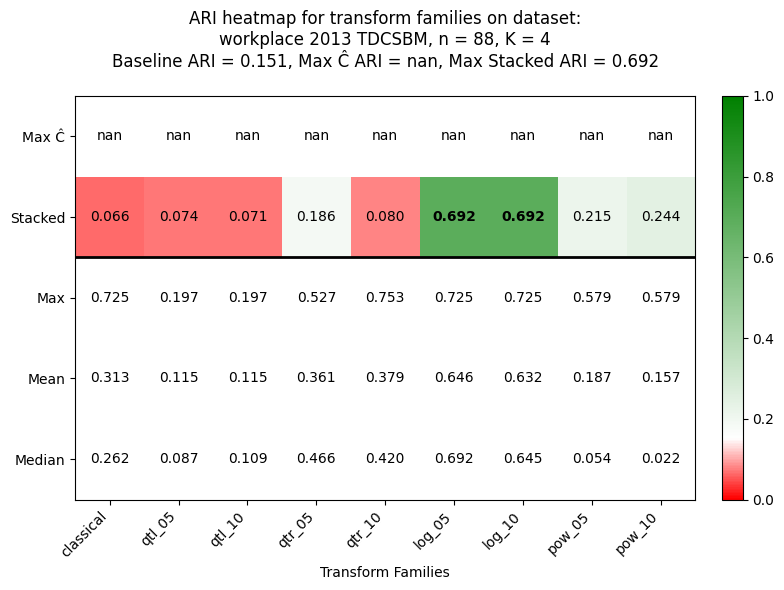

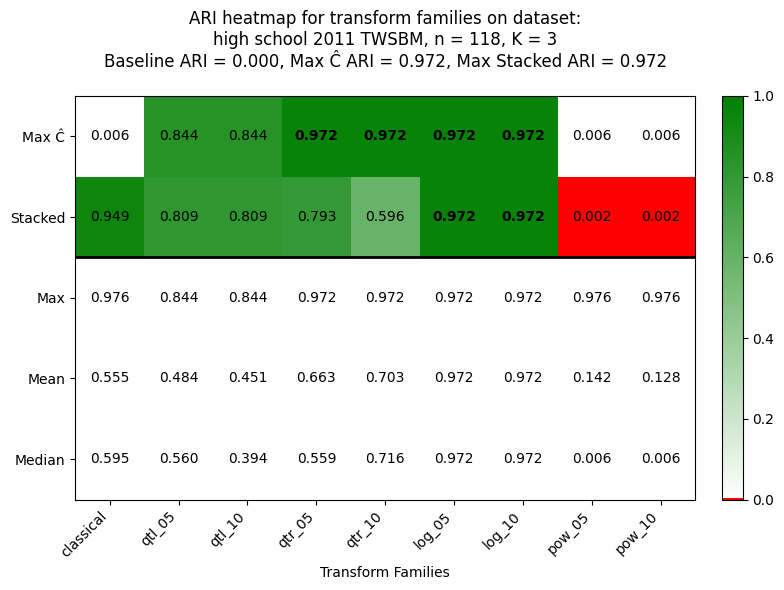

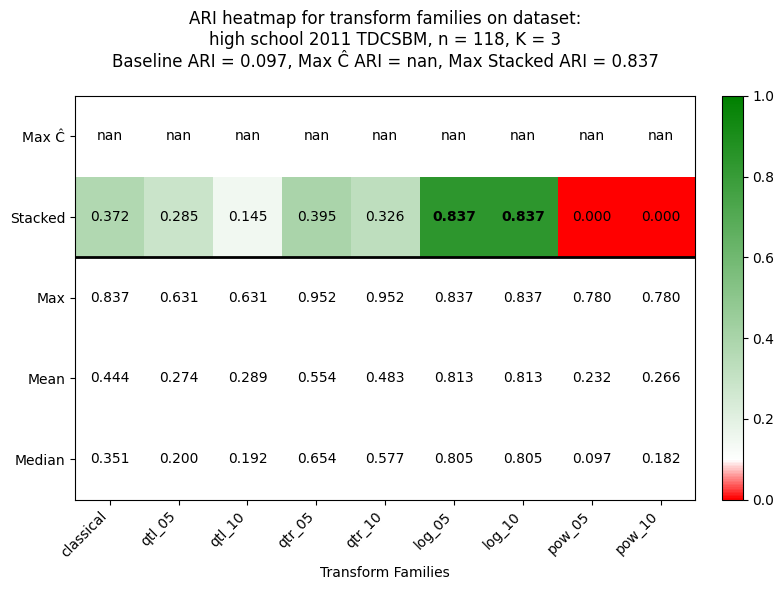

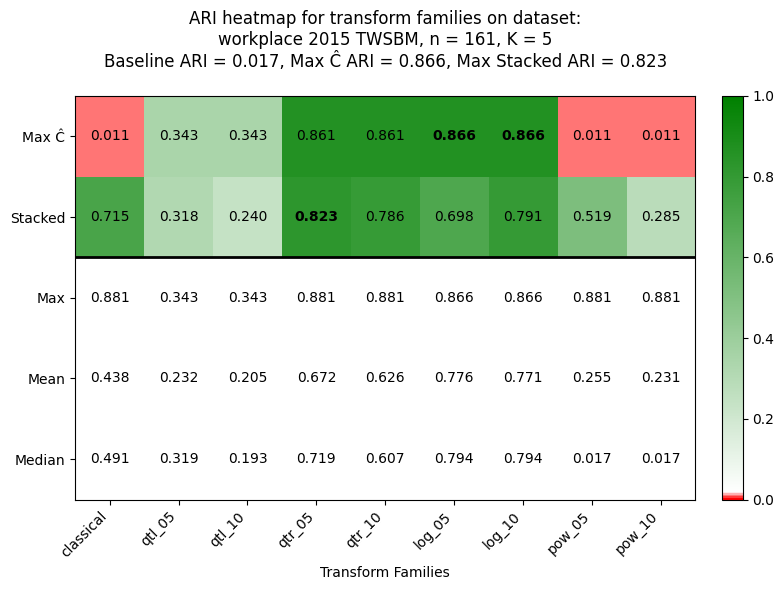

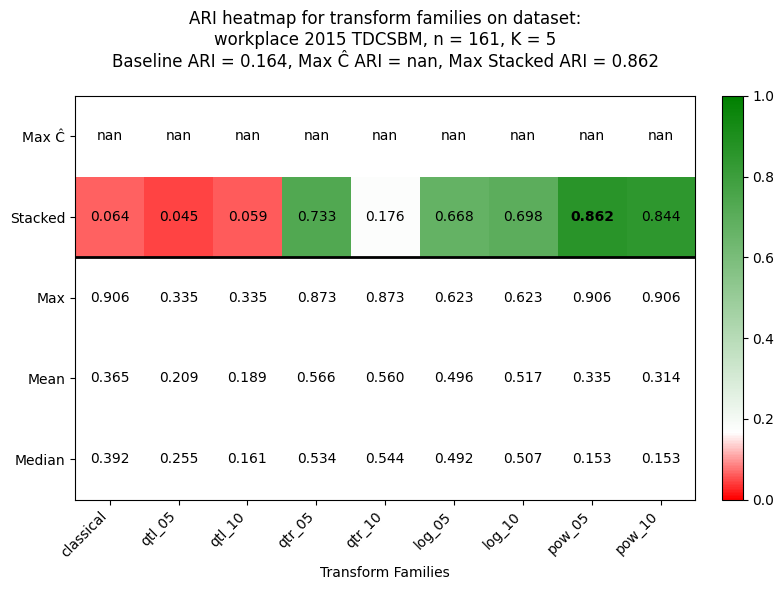

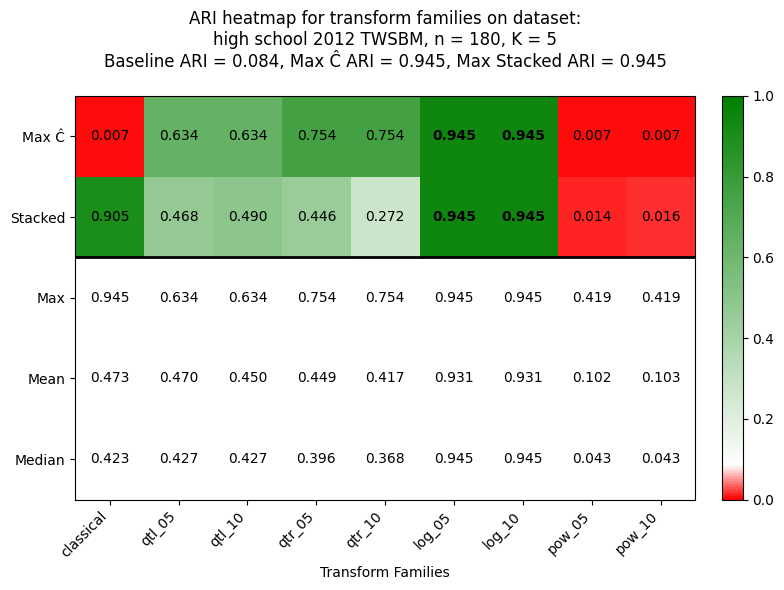

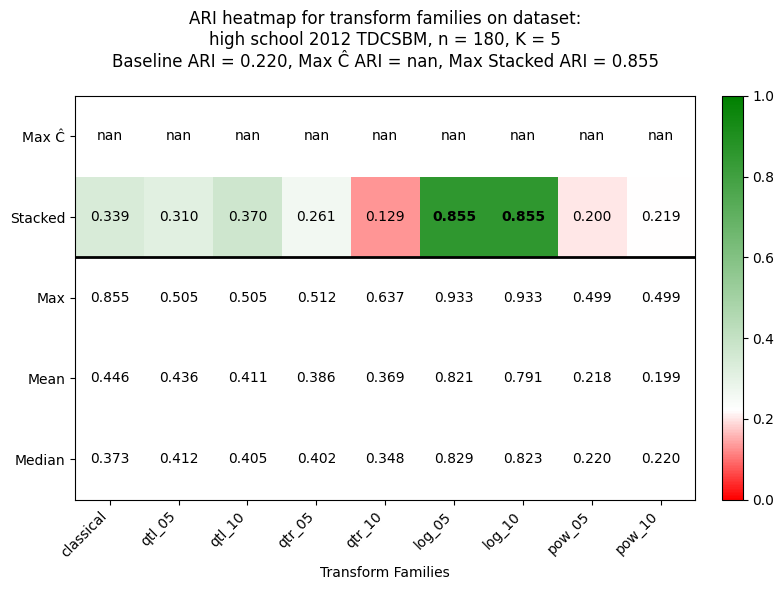

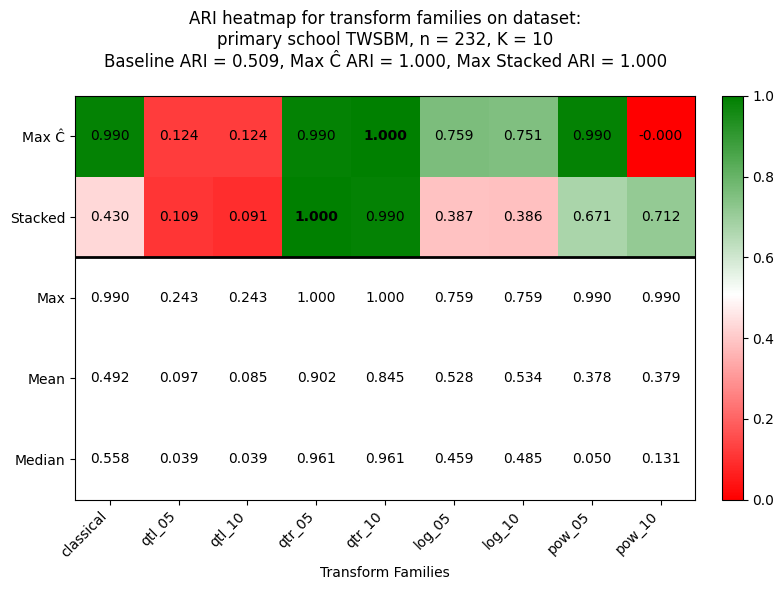

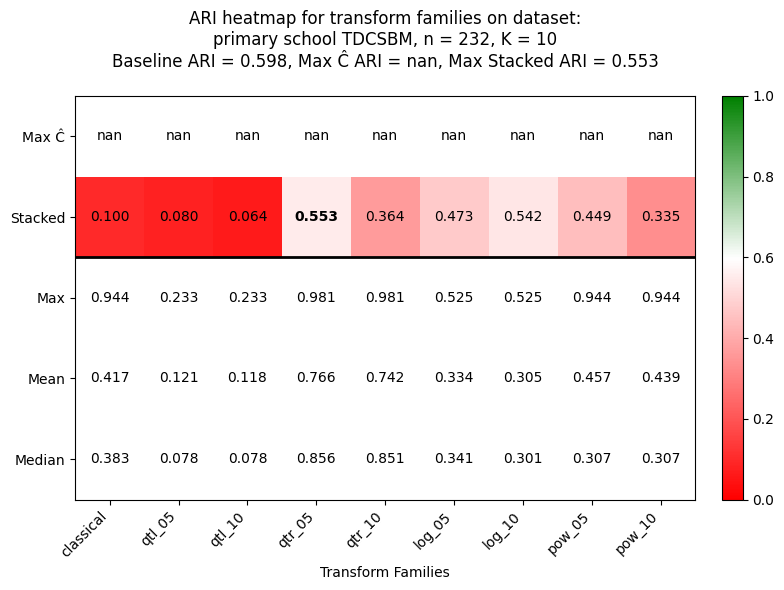

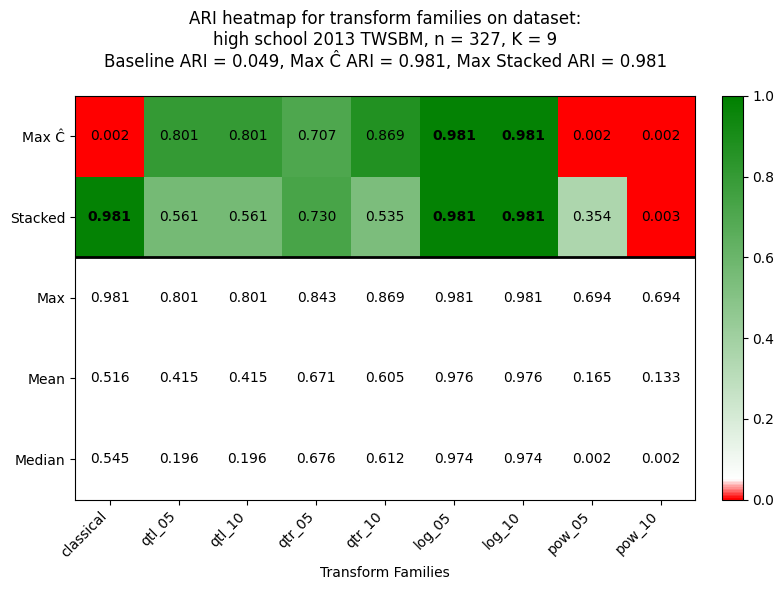

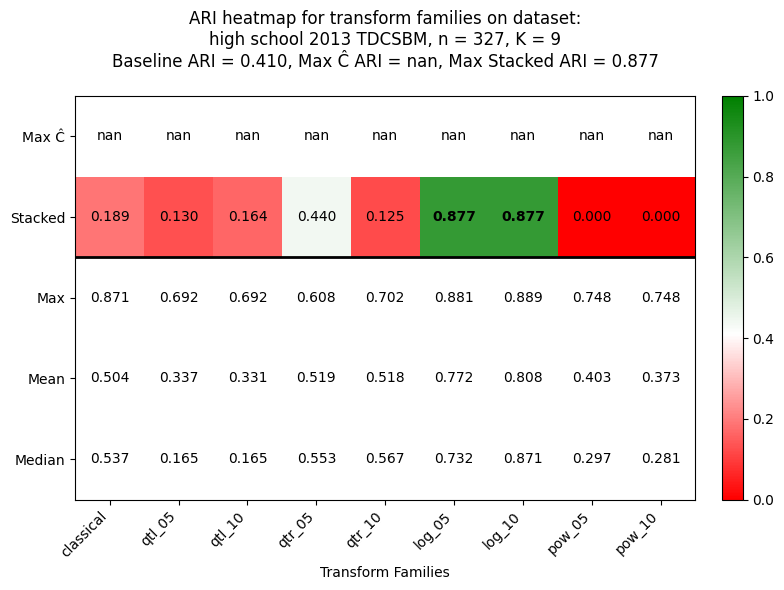

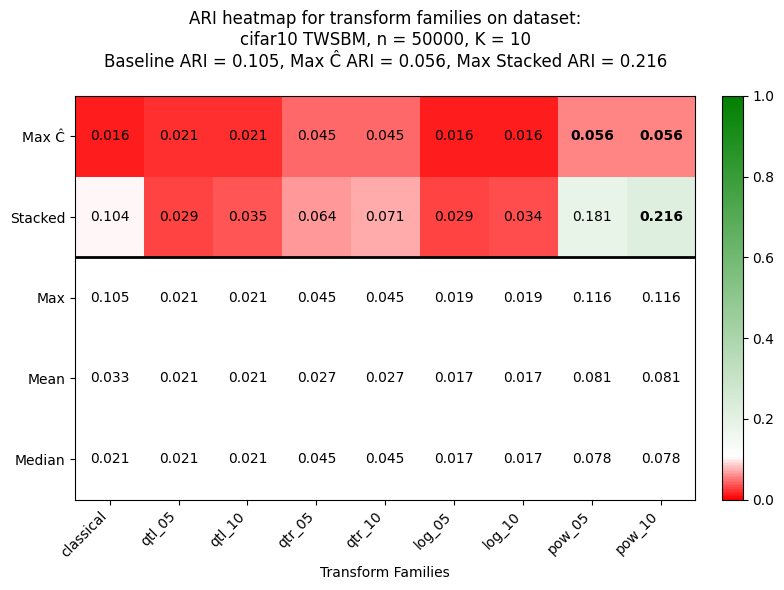

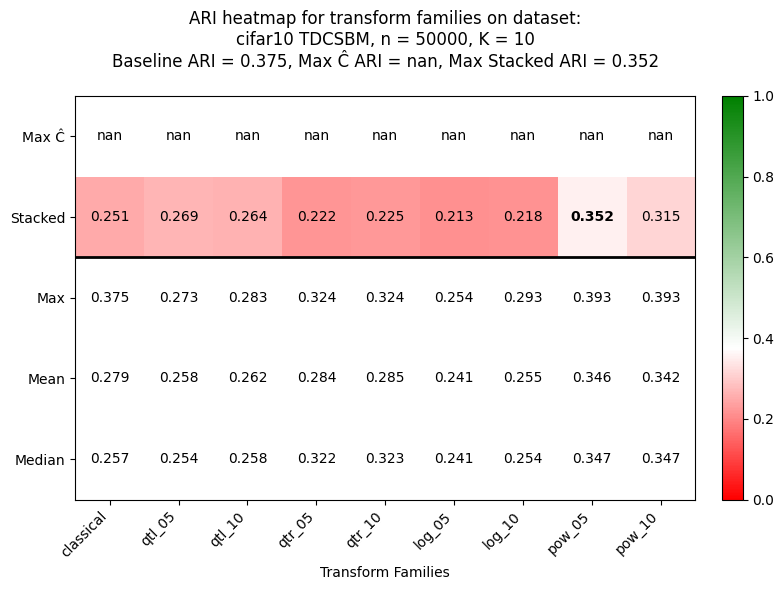

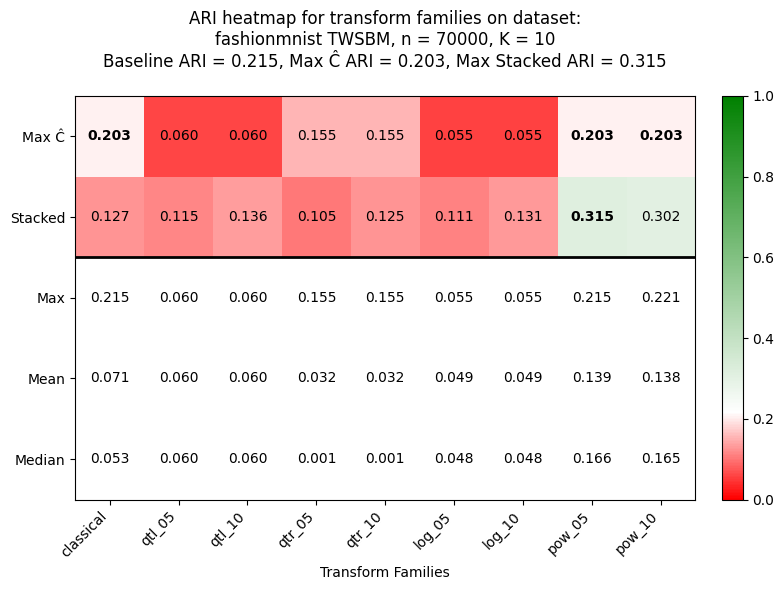

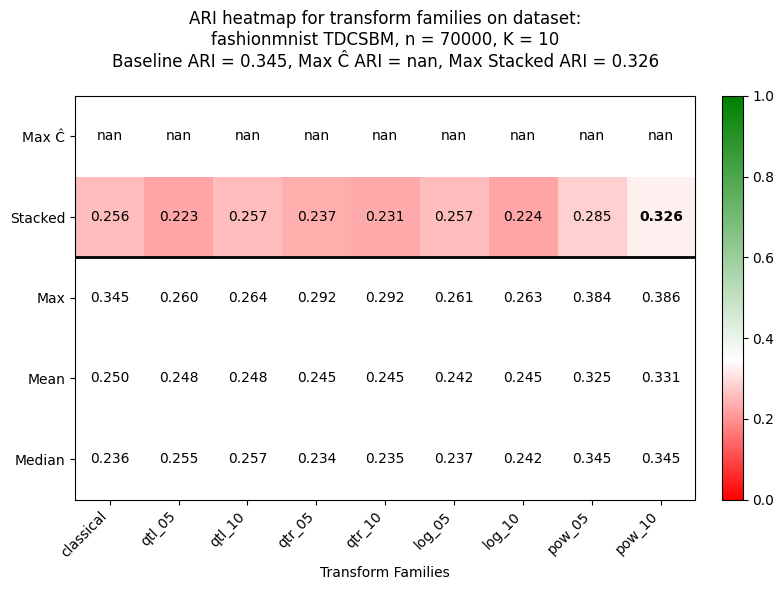

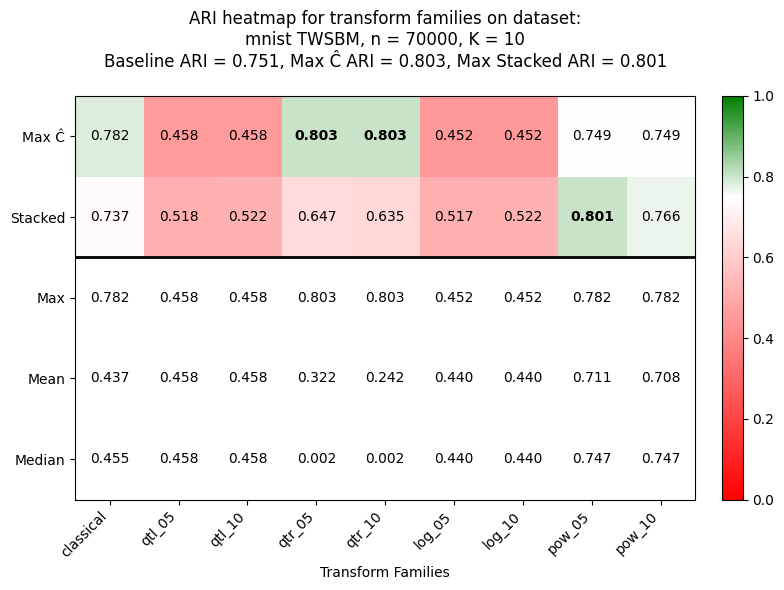

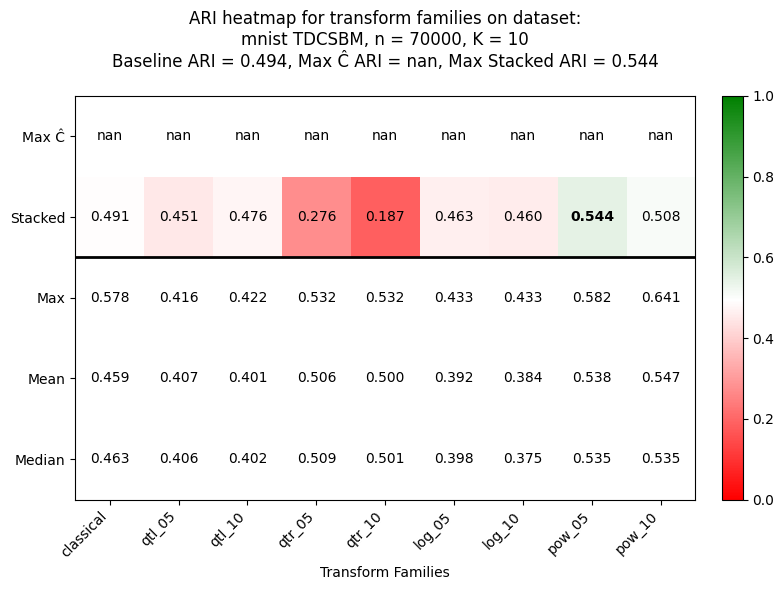

In [23]:
for name, d in df_dict_real.items():
	plot_heatmap_families(name, d['df_families'], d['metadata'])

#### Transforms ARI bar charts

In [24]:
for name, d in df_dict_real.items():
	plot_bars_transforms(name, d['df_transforms'], d['metadata'])

#### Families ARI bar charts v1

In [25]:
for name, d in list(df_dict_real.items())[::2]:
	plot_bars_families_v1(name, d['df_families'], d['metadata'], sort_by='Max Ĉ', show_values=True)

#### Families ARI bar charts v2

In [26]:
for name, d in df_dict_real.items():
	plot_bars_families_v2(name, d['df_families'], d['metadata'])